In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#
# Standard Library Imports
#
import time
import math

#
# Plotting Imports
#
import matplotlib
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from matplotlib import gridspec

#
# Numerical Mathematics Imports
#
import numpy as np
import scipy.sparse as sp
import numpy.linalg as la
from scipy import interpolate
from scipy.special import expit

#
# Symbolic Mathematics Imports
#
import sympy
import sympy.matrices
import sympy.physics
import sympy.physics.mechanics
import sympy.physics.mechanics.functions

#
# Nonlinear Optimization Imports
#
from optimize.snopt7 import SNOPT_solver

#
# Stanford Quadrotor-specific Code
#
import pathutils
pathutils.add_relative_to_current_source_file_path_to_sys_path("/Users/njoubert/Code/Frankencopter/Code/")

import flashlight.sympyutils as sympyutils

#
# Configuration
#
sympy.physics.mechanics.functions.mechanics_printing(use_latex="mathjax", latex_mode="equation")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Messing Around with SymPy

In [109]:
#
# Let's build an expression and have a function to evaluate it
#

x1, x2, x3 = sympy.symbols('x_1 x_2 x_3')
expr = 2*x1 + x2**x3
print "My expression is:", expr

#
# Evaluate by Substitution
#

simpl = expr.subs([(x1, 1), (x2, 2), (x3, 2)])
print "Simplify with {x1 = 1, x2 = 2, x3 = 2} == ", simpl
print "Evaluate into float == ", simpl.evalf()
print "Evaluate with subs (recommended method) == ", expr.evalf(subs={x1: 1, x2: 2, x3: 2})

#
# Convert expression into anonymous function
#
func = sympy.lambdify([x1, x2, x3], expr, 'numpy')
print "Converted symbolic expression into lambda:", type(func)
print "Calling with args (1, 2, 2) == ", func(1, 2, 2)


My expression is: 2*x_1 + x_2**x_3
Simplify with {x1 = 1, x2 = 2, x3 = 2} ==  6
Evaluate into float ==  6.00000000000000
Evaluate with subs (recommended method) ==  6.00000000000000
Converted symbolic expression into lambda: <type 'function'>
Calling with args (1, 2, 2) ==  6


In [126]:
#
# Now let's try out a vector
#

def add(A_expr, el):
    if not isinstance(A_expr,sympy.Matrix):
        A_square_expr = A_expr + el
    else:
        A_square_expr = sympy.Matrix.zeros(A_expr.rows,A_expr.cols)
        for r in range(A_expr.rows):
            for c in range(A_expr.cols):
                A_square_expr[r,c] = A_expr[r,c] + el
    return A_square_expr

nsamples = 10
# Construct a column vector of nsamples entries
w, w_entries = sympyutils.construct_matrix_and_entries("w", (nsamples, 1))

# Construct an expression of this column vector
energy = sympyutils.sum(sympyutils.square(add(w, -0.5)))
print "Energy expression is:", energy

# Create an anonymous function to evaluate this expression
func_e = sympy.lambdify(w, energy)

# Evaluate this expression with dummy data
vals = np.zeros((nsamples, 1)) + 1
print "Evaluated energy expression with all w = 1:", func_e(*vals)

Energy expression is: (w_0_0 - 0.5)**2 + (w_1_0 - 0.5)**2 + (w_2_0 - 0.5)**2 + (w_3_0 - 0.5)**2 + (w_4_0 - 0.5)**2 + (w_5_0 - 0.5)**2 + (w_6_0 - 0.5)**2 + (w_7_0 - 0.5)**2 + (w_8_0 - 0.5)**2 + (w_9_0 - 0.5)**2
Evaluated energy expression with all w = 1: [ 2.5]


In [135]:
#
# Now let's try setting up a jacobian matrix
#
obj = sympy.Matrix.zeros(1,1)
obj[0,0] = energy
obj.jacobian(w).transpose()

⎡2⋅w₀ ₀ - 1.0⎤
⎢            ⎥
⎢2⋅w₁ ₀ - 1.0⎥
⎢            ⎥
⎢2⋅w₂ ₀ - 1.0⎥
⎢            ⎥
⎢2⋅w₃ ₀ - 1.0⎥
⎢            ⎥
⎢2⋅w₄ ₀ - 1.0⎥
⎢            ⎥
⎢2⋅w₅ ₀ - 1.0⎥
⎢            ⎥
⎢2⋅w₆ ₀ - 1.0⎥
⎢            ⎥
⎢2⋅w₇ ₀ - 1.0⎥
⎢            ⎥
⎢2⋅w₈ ₀ - 1.0⎥
⎢            ⎥
⎣2⋅w₉ ₀ - 1.0⎦

# Test 1: Get SymPy + Snopt running with (0,1) constraints on X

  Could not determine Jacobian structure from user input
  Calling snJac...


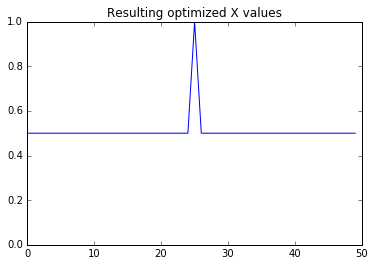

In [145]:
#
# Attempt to express Test 1 using SymPy to set up everything.
#

from optimize.snopt7 import SNOPT_solver
import numpy as np

inf = 1.0e20

snopt = SNOPT_solver()
snopt.setOption('Verbose',False)
snopt.setOption('Solution print',True)
snopt.setOption('Print file','blend_test1.out')

nsamples = 50

# 1. Set up decision variables
x, x_entries = sympyutils.construct_matrix_and_entries("w", (nsamples, 1))

# 2. Set up the bounds on x
low_x = np.array([0.0]*nsamples)
upp_x = np.array([1.0]*nsamples)

# 3. Set up the objective function
energy = sympyutils.sum(sympyutils.square(add(x, -0.5)))
func_e = sympy.lambdify(x, energy)

def blend_test1_objF(status,x,needF,needG,cu,iu,ru):
    obj = np.array([func_e(*x)])
    return status, obj

# 4. Set up bounds on F
low_F    = np.array([ -inf])
upp_F    = np.array([  inf])

# 5. Lets set up an equality constraint on one of the centerpoints
low_x[nsamples/2] = 1.0

# We first solve the problem without providing derivative info
snopt.snopta(name='blend_test1',x0=x0,xlow=low_x,xupp=upp_x,
             Flow=low_F,Fupp=upp_F,ObjRow=1,
             usrfun=blend_test1_objF)

plt.plot(snopt.x)
plt.ylim([0,1])
plt.title("Resulting optimized X values")

# Test 2: Express C4 Continuity Constraints and a single simple obstacle

## Subtest 1: Write out the full matrices...

In [167]:

nsamples = 50
ndims = 6
nvars = ndims * nsamples

# Set up decision variables
X = sympy.Matrix.zeros(nsamples, ndims)
for r in range(nsamples):
    for c in range(ndims):
        X[r,c] = sympy.Symbol("w_%d,%d" % (r, c))

X0 = X.reshape(nvars,1)

